# Обработчик таблиц и диаграм из файла .log MOLCAS

1) Импортируем библиотеку pandas для удобства работы
2) В той же папке, в которой лежит этот рабочий документ оставляем результат работы MOLCAS

In [5]:
filename = 'UMITOB_d4d'
path = f'./logs/{filename}.log'

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from docx import Document
from docx.shared import Inches
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm
from IPython.display import display

In [7]:
def add_table_to_report(df, doc):
    # Добавляем таблицу
    table = doc.add_table(rows=1, cols=len(df.columns))

    # Добавляем заголовки столбцов
    hdr_cells = table.rows[0].cells
    for i, column in enumerate(df.columns):
        hdr_cells[i].text = str(column)

    # Добавляем данные из DataFrame
    for index, row in df.iterrows():
        row_cells = table.add_row().cells
        for i, value in enumerate(row):
            row_cells[i].text = str(value)  

In [8]:
doc = Document()

doc.add_heading(filename, level=1)

with open(f'./master/logs/{filename}.log', 'r') as file:
    lines = file.readlines()

## Создаем таблицу с компонентами g-тезора

In [9]:
def extract_pseudospin_hamiltonian(lines):
    """Извлекает строки, содержащие данные о псевдоспиновых гамильтонианах."""
    output_lines = []
    found = False

    for line in lines:
        if "CALCULATION OF PSEUDOSPIN HAMILTONIAN TENSORS FOR THE MULTIPLET 1" in line:
            found = True
        if found:
            output_lines.append(line)
            if len(output_lines) == 1200:  # Ограничиваем количество записей
                break

    return output_lines

def parse_g_values(output_lines):
    """Парсит значения g_x, g_y, g_z из output_lines и возвращает списки."""
    gx = []
    gy = []
    gz = []

    for output_line in output_lines:
        if "gX =" in output_line:
            gx.append(float(output_line[7:25].strip()))
        if "gY =" in output_line:
            gy.append(float(output_line[7:25].strip()))
        if "gZ =" in output_line:
            gz.append(float(output_line[7:25].strip()))

    return gx, gy, gz

def create_g_dataframe(gx, gy, gz):
    """Создает DataFrame из списков g_x, g_y, g_z."""
    return pd.DataFrame({
        'KD': range(1, len(gx) + 1),
        'g_x': gx,
        'g_y': gy,
        'g_z': gz
    })

def add_pseudospin_to_report(gx_gy_gz_df, doc):
    """Добавляет заголовок и таблицу псевдоспиновых гамильтонианов в документ."""
    doc.add_heading('\n\nPSEUDOSPIN HAMILTONIAN TENSORS', level=1)
    add_table_to_report(gx_gy_gz_df, doc)

def process_pseudospin_hamiltonian(lines, doc):
    """Основная функция для обработки данных о псевдоспиновых гамильтонианах."""
    output_lines = extract_pseudospin_hamiltonian(lines)
    gx, gy, gz = parse_g_values(output_lines)
    gx_gy_gz_df = create_g_dataframe(gx, gy, gz)
    gx_gy_gz_df.set_index("KD", inplace=True)  # Устанавливаем KD как индекс
    add_pseudospin_to_report(gx_gy_gz_df, doc)

# Пример использования
# Предполагается, что lines и doc уже определены
process_pseudospin_hamiltonian(lines, doc)

## Создаем диаграмму с эненргетическими уровнями и тепловую матрицу

### Формируем датафрейм для ab-initio barrier

Код работает точно также, как и в предыдущем случае, только для другого блока .log файла


In [10]:

def extract_ab_initio_blocking_barrier(lines):
    """Извлекает блок данных AB INITIO BLOCKING BARRIER из списка строк."""
    found = False
    output_lines = []

    for line in lines:
        if "AB INITIO BLOCKING BARRIER" in line:
            found = True
        if found:
            output_lines.append(line)
            if len(output_lines) == 18:  # Ограничиваем количество записей
                break

    return output_lines

def parse_output_lines(output_lines):
    """Парсит извлеченные строки и возвращает списки значений."""
    m_pos = []
    m_neg = []
    energy = []

    for output_line in output_lines[9:17]:  # Извлекаем нужные строки
        m_pos.append(float(output_line[8:20].strip()))
        m_neg.append(float(output_line[24:33].strip()))
        energy.append(float(output_line[36:49].strip()))

    return m_pos, m_neg, energy

def create_dataframe(m_pos, m_neg, energy):
    """Создает DataFrame из списков значений."""
    return pd.DataFrame({
        'KD': range(1, 9),
        'l+, muB': m_pos,
        'l-, muB': m_neg,
        'E, cm-1': energy
    })

def add_ab_initio_blocking_barrier_to_report(df, doc):
    """Добавляет заголовок и таблицу в документ."""
    doc.add_heading('\n\nAB INITIO BLOCKING BARRIER', level=1)
    add_table_to_report(df, doc)

def process_ab_initio_blocking_barrier(lines, doc):
    """Основная функция для обработки данных AB INITIO BLOCKING BARRIER."""
    output_lines = extract_ab_initio_blocking_barrier(lines)
    m_pos, m_neg, energy = parse_output_lines(output_lines)
    ab_initio_barrier_df = create_dataframe(m_pos, m_neg, energy)
    add_ab_initio_blocking_barrier_to_report(ab_initio_barrier_df, doc)
    return ab_initio_barrier_df

# Пример использования
# Предполагается, что lines и doc уже определены
ab_initio_barrier_df = process_ab_initio_blocking_barrier(lines, doc)
ab_initio_barrier_df

,KD,"l+, muB","l-, muB","E, cm-1"
0,1,-9.815839,9.815839,0.000000
1,2,-7.935869,7.935869,163.886573
2,3,-5.642182,5.642182,235.493651
3,4,-3.660877,3.660877,279.339695
4,5,-2.155746,2.155746,311.392814
5,6,-4.016738,4.016738,398.170736
6,7,-1.974407,1.974407,433.756496
7,8,-5.426782,5.426782,535.094119


### Обработка матричных элементов

В этом блоке, получим тепловую карту для матрицных элементов между противоположными уровнями, тут будут изображены процессы QTM и TA-QTM на диагональных элементах, а процесс релаксации Орбаха на элементах выше диагонали


In [11]:
import pandas as pd

def create_heat_map_dataframe(heat_map):
    """Создает DataFrame из heat_map с числовыми индексами и именами столбцов."""
    return pd.DataFrame(
        heat_map,
        index=range(len(heat_map)),
        columns=range(len(heat_map[0]))
    )

# Пример использования
def extract_ab_initio_blocking_barrier(lines):
    """Извлекает блок данных AB INITIO BLOCKING BARRIER из списка строк."""
    output_lines = []
    found = False

    for line in lines:
        if "AB INITIO BLOCKING BARRIER" in line:
            found = True
        if found:
            output_lines.append(line)
            if len(output_lines) == 350:  # Ограничиваем количество записей
                break

    return output_lines

def initialize_heat_map(size=8):
    """Инициализирует матрицу heat_map заданного размера."""
    return [[0.0 for _ in range(size)] for _ in range(size)]

def fill_heat_map(output_lines, heat_map):
    """Заполняет элементы матрицы heat_map на основе output_lines."""
    for output_line in output_lines:
        for i in range(len(heat_map)):
            for j in range(len(heat_map[i])):
                if f"< {i + 1}.1+ | mu_Y | {j + 1}.1- >" in output_line:
                    heat_map[i][j] = float(output_line[75:94].strip())

def add_heat_map_to_report(heat_map_df, doc):
    """Добавляет заголовок и таблицу heat_map в документ."""
    doc.add_heading('\n\nQTM, ORBACH, MATRIX ELEMENTS', level=1)
    add_table_to_report(heat_map_df, doc)

def process_ab_initio_blocking_barrier(lines, doc):
    """Основная функция для обработки данных AB INITIO BLOCKING BARRIER и создания heat_map."""
    output_lines = extract_ab_initio_blocking_barrier(lines)
    heat_map = initialize_heat_map()
    fill_heat_map(output_lines, heat_map)
    heat_map_df = create_heat_map_dataframe(heat_map)
    add_heat_map_to_report(heat_map_df, doc)

    # Отображаем результат
    # print(heat_map_df)  # Вывод в консоль
    display(heat_map_df)  # Отображение в Jupyter Notebook, если используется
    return heat_map_df

# Пример использования
# Предполагается, что lines и doc уже определены
heat_map_df = process_ab_initio_blocking_barrier(lines, doc)



,0,1,2,3,4,5,6,7
0,0.001536,0.006079,0.017429,0.075567,0.082685,0.039478,0.014034,0.005263
1,0.000000,0.024191,0.079145,0.289163,0.255043,0.087098,0.136839,0.034134
2,0.000000,0.000000,0.323860,0.723187,0.461304,0.076032,0.534648,0.133258
3,0.000000,0.000000,0.000000,1.168411,1.385984,0.298404,1.010154,0.207698
4,0.000000,0.000000,0.000000,0.000000,2.518084,0.719533,0.948988,0.475878
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.112793,0.193596,0.463986
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071837,0.044673
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016456


### Вторая тепловая карта

На этой диаграмме изображены матричные элементы, соответствующие прямому процессу.

In [12]:
def extract_ab_initio_blocking_barrier(lines):
    """Извлекает блок данных AB INITIO BLOCKING BARRIER из списка строк."""
    output_lines = []
    found = False

    for line in lines:
        if "AB INITIO BLOCKING BARRIER" in line:
            found = True
        if found:
            output_lines.append(line)
            if len(output_lines) == 350: 
                break

    return output_lines

def initialize_heat_map(size=8):
    """Инициализирует матрицу heat_map заданного размера."""
    return [[0.0 for _ in range(size)] for _ in range(size)]

def fill_heat_map_dir(output_lines, heat_map_dir):
    """Заполняет элементы матрицы heat_map_dir на основе output_lines."""
    for output_line in output_lines:
        for i in range(len(heat_map_dir)):
            for j in range(len(heat_map_dir[i])):
                if f"< {i + 1}.1+ | mu_Y | {j + 1}.1+ >" in output_line:
                    heat_map_dir[i][j] = float(output_line[75:94].strip())

def create_heat_map_dir_dataframe(heat_map_dir):
    """Создает DataFrame из heat_map_dir."""
    return pd.DataFrame(heat_map_dir)

def add_heat_map_dir_to_report(heat_map_dir_df, doc):
    """Добавляет заголовок и таблицу heat_map_dir в документ."""
    doc.add_heading('\n\nDIRECT MATRIX ELEMENTS', level=1)
    add_table_to_report(heat_map_dir_df, doc)

def process_ab_initio_blocking_barrier(lines, doc):
    """Основная функция для обработки данных AB INITIO BLOCKING BARRIER и создания heat_map_dir."""
    output_lines = extract_ab_initio_blocking_barrier(lines)
    heat_map_dir = initialize_heat_map()
    fill_heat_map_dir(output_lines, heat_map_dir)
    heat_map_dir_df = create_heat_map_dir_dataframe(heat_map_dir)
    add_heat_map_dir_to_report(heat_map_dir_df, doc)
    
    # Отображаем результат
    display(heat_map_dir_df) 

    return heat_map_dir
    

# Пример использования
# Предполагается, что lines и doc уже определены
heat_map_dir = process_ab_initio_blocking_barrier(lines, doc)


,0,1,2,3,4,5,6,7
0,3.271946,1.904099,0.406856,0.282231,0.184930,0.133334,0.210526,0.331597
1,0.000000,3.065817,2.507843,1.069491,0.604877,0.333060,0.502738,0.597076
2,0.000000,0.000000,3.570741,2.915424,1.046444,0.569463,0.654143,0.622086
3,0.000000,0.000000,0.000000,2.400129,2.891154,0.811219,1.255755,0.768737
4,0.000000,0.000000,0.000000,0.000000,2.381796,1.891291,1.158109,0.446858
5,0.000000,0.000000,0.000000,0.000000,0.000000,5.422509,0.546644,0.127398
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.021404,2.075765
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.351866


## Энергетическая диаграмма

Пробуем построить внятную диаграмму с подписями

[-9.8158394, -7.9358693]
[-9.8158394, -5.6421818]
[-7.9358693, -5.6421818]
[-7.9358693, -3.6608772]
[-5.6421818, -3.6608772]


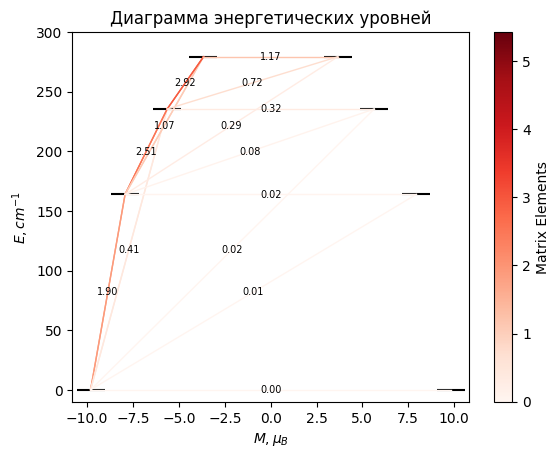

In [13]:

# Объединяем данные для осей x и y
resultx = pd.concat([ab_initio_barrier_df['l+, muB'], ab_initio_barrier_df['l-, muB']], ignore_index=True, sort=False)
resulty = pd.concat([ab_initio_barrier_df['E, cm-1'], ab_initio_barrier_df['E, cm-1']], ignore_index=True, sort=False)
levels = 4
# Создаем нормализатор для значений матричных элементов
all_matrix_values_dir = [float(value) for inner_list in heat_map_dir for value in inner_list if isinstance(value, (int, float))]
all_matrix_values_df = [float(value) for inner_list in heat_map_df.values for value in inner_list if isinstance(value, (int, float))]
all_matrix_values = all_matrix_values_dir + all_matrix_values_df
norm = Normalize(vmin=min(all_matrix_values), vmax=max(all_matrix_values))

# Соединяем уровни линиями
for i in range(levels):
    for j in range(levels):
        # Не соединяем уровень с самим собой
        if i != j and j > i and j - i < 3:
            # Получаем координаты
            x_values = [ab_initio_barrier_df['l+, muB'].iloc[i], ab_initio_barrier_df['l+, muB'].iloc[j]]
            y_values = [ab_initio_barrier_df['E, cm-1'].iloc[i], ab_initio_barrier_df['E, cm-1'].iloc[j]]
            print(x_values)
            # Получаем значение матричного элемента
            matrix_value = heat_map_dir[i][j]

            # Пропускаем, если значение матричного элемента равно нулю
            if matrix_value == 0:
                continue

            # Определяем цвет линии с использованием палитры Reds
            color = plt.cm.Reds(norm(matrix_value))  # Используем colormap для получения цвета

            # Рисуем линию
            plt.plot(x_values, y_values, color=color, linewidth=1)

            # Добавляем подпись к линии
            mid_x = (x_values[0] + x_values[1]) / 2
            mid_y = (y_values[0] + y_values[1]) / 2
            plt.text(mid_x, mid_y, f'{matrix_value:.2f}', fontsize=7, ha='center', va='center', color='black')

            if i < j:
                x_values = [ab_initio_barrier_df['l+, muB'].iloc[i], ab_initio_barrier_df['l+, muB'].iloc[j]]
                y_values = [ab_initio_barrier_df['E, cm-1'].iloc[i], ab_initio_barrier_df['E, cm-1'].iloc[j]]

                # Получаем значение матричного элемента
                matrix_value = heat_map_dir[i][j]

                # Пропускаем, если значение матричного элемента равно нулю
                if matrix_value == 0:
                    continue

                # Определяем цвет линии с использованием палитры Reds
                color = plt.cm.Reds(norm(matrix_value))  # Используем colormap для получения цвета

                # Рисуем линию
                plt.plot(x_values, y_values, color=color, linewidth=1)

                # Добавляем подпись к линии
                mid_x = (x_values[0] + x_values[1]) / 2
                mid_y = (y_values[0] + y_values[1]) / 2
                #plt.text(mid_x, mid_y, f'{matrix_value:.2f}', fontsize=6, ha='center', va='center', color='black')

# Соединяем уровни линиями
for i in range(levels):
    for j in range(levels):
        # Не соединяем уровень с самим собой
        if i == j:
            # Получаем координаты
            x_values = [ab_initio_barrier_df['l+, muB'].iloc[i], ab_initio_barrier_df['l-, muB'].iloc[j]]
            y_values = [ab_initio_barrier_df['E, cm-1'].iloc[i], ab_initio_barrier_df['E, cm-1'].iloc[j]]

            # Получаем значение матричного элемента
            matrix_value = heat_map_df[i][j]

            # Пропускаем, если значение матричного элемента равно нулю
            if matrix_value == 0:
                continue

            # Определяем цвет линии с использованием палитры Reds
            color = plt.cm.Reds(norm(matrix_value))  # Используем colormap для получения цвета

            # Рисуем линию
            plt.plot(x_values, y_values, color=color, linewidth=1)

            # Добавляем подпись к линии
            mid_x = (x_values[0] + x_values[1]) / 2
            mid_y = (y_values[0] + y_values[1]) / 2
            plt.text(mid_x, mid_y, f'{matrix_value:.2f}', fontsize=7, ha='center', va='center', color='black')

# Соединяем уровни линиями
for i in range(levels):
    for j in range(levels):
        # Не соединяем уровень с самим собой
        if i > j and i - j < 3:
            # Получаем координаты
            x_values = [ab_initio_barrier_df['l-, muB'].iloc[i], ab_initio_barrier_df['l+, muB'].iloc[j]]
            y_values = [ab_initio_barrier_df['E, cm-1'].iloc[i], ab_initio_barrier_df['E, cm-1'].iloc[j]]

            # Получаем значение матричного элемента
            matrix_value = heat_map_df[i][j]

            # Пропускаем, если значение матричного элемента равно нулю
            if matrix_value == 0:
                continue

            # Определяем цвет линии с использованием палитры Reds
            color = plt.cm.Reds(norm(matrix_value))  # Используем colormap для получения цвета

            # Рисуем линию
            plt.plot(x_values, y_values, color=color, linewidth=1)

            # Добавляем подпись к линии
            mid_x = (x_values[0] + x_values[1]) / 2
            mid_y = (y_values[0] + y_values[1]) / 2
            plt.text(mid_x, mid_y, f'{matrix_value:.2f}', fontsize=7, ha='center', va='center', color='black')

# Устанавливаем пределы осей
plt.xlim(min(resultx) - 1, max(resultx) + 1)  # Добавляем немного отступа
plt.ylim(min(resulty) - 10, 300)  # Добавляем немного отступа

plt.xlabel('$M, \mu_{B}$')
plt.ylabel('$E, cm^{-1}$')
plt.title('Диаграмма энергетических уровней')

# Убираем линии сетки
plt.grid(False)
plt.scatter(resultx, resulty, s=390, marker='_', color='black')

# Добавляем цветовую шкалу
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Reds'), ax=plt.gca())
cbar.set_label('Matrix Elements')

# Сохраняем график
plt.savefig('Diagram.png')
plt.savefig('Diagram.svg')
doc.add_heading('\n\nDiagram', level=1)
doc.add_picture('Diagram.png', width=Inches(5))
plt.show()


## Коэффициенты Стивенсона

{'B2 -2': 1.2464399324013, 'B2 -1': 0.56462128667626, 'B2 0': -1.7933084711723, 'B2 1': 2.5286449635693, 'B2 2': 0.82401856371447, 'B4 -4': -0.0099520853001554, 'B4 -3': 0.023675784872272, 'B4 -2': 0.029917883745086, 'B4 -1': 0.011046782266583, 'B4 0': -0.0046770792855499, 'B4 1': -0.0085809693708066, 'B4 2': 0.003122703898804, 'B4 3': 0.0080232201231758, 'B4 4': -0.0058200460241862, 'B6 -6': -0.00010396620547814, 'B6 -5': -0.00035454529583899, 'B6 -4': 0.000120658248756, 'B6 -3': 0.00018821260660608, 'B6 -2': -6.1527407407206e-05, 'B6 -1': -0.00014177909378597, 'B6 0': -9.815538574471e-06, 'B6 1': -1.9470047235583e-05, 'B6 2': 9.1116251235847e-05, 'B6 3': -0.0002733551839326, 'B6 4': -0.00013726301656411, 'B6 5': -2.4158043891477e-05, 'B6 6': -2.0622503199831e-05}


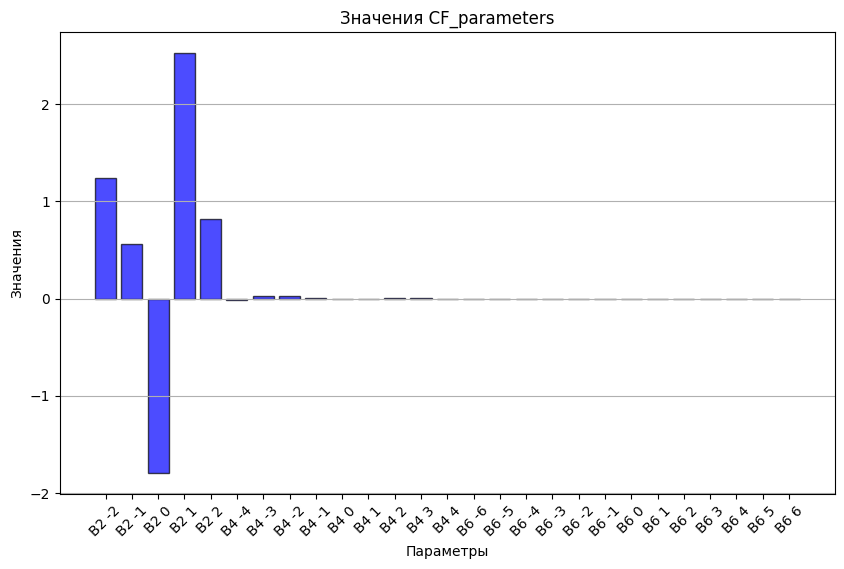

In [14]:
def extract_crystal_field_parameters(lines):
    """Извлекает строки, содержащие данные о параметрах кристаллического поля."""
    output_lines = []
    found = False

    for line in lines:
        if "CALCULATION OF CRYSTAL-FIELD PARAMETERS OF THE GROUND ATOMIC MULTIPLET J = " in line:
            found = True
        if found:
            output_lines.append(line)
            if len(output_lines) == 300:  # Ограничиваем количество записей
                break

    return output_lines

def parse_crystal_field_parameters(output_lines):
    """Парсит данные из output_lines и возвращает словарь CF_parameters."""
    CF_parameters = {}

    for output_line in output_lines:
        for i in range(-2, 0):
            if f" 2 |  {i} |" in output_line:
                CF_parameters[f'B2 {i}'] = float(output_line[25:-2].strip())
        for i in range(0, 3):
            if f" 2 |   {i} |" in output_line:
                CF_parameters[f'B2 {i}'] = float(output_line[25:-2].strip())
        for i in range(-4, 0):
            if f" 4 |  {i} |" in output_line:
                CF_parameters[f'B4 {i}'] = float(output_line[25:-2].strip())
        for i in range(0, 5):
            if f" 4 |   {i} |" in output_line:
                CF_parameters[f'B4 {i}'] = float(output_line[25:-2].strip())
        for i in range(-6, 0):
            if f" 6 |  {i} |" in output_line:
                CF_parameters[f'B6 {i}'] = float(output_line[25:-2].strip())
        for i in range(0, 7):
            if f" 6 |   {i} |" in output_line:
                CF_parameters[f'B6 {i}'] = float(output_line[25:-2].strip())

    return CF_parameters

def plot_crystal_field_parameters(CF_parameters):
    """Создает график значений CF_parameters."""
    labels = list(CF_parameters.keys())
    values = list(CF_parameters.values())

    plt.figure(figsize=(10, 6))
    plt.bar(labels, values, color='blue', alpha=0.7, edgecolor='black')

    # Настраиваем график
    plt.title('Значения CF_parameters')
    plt.xlabel('Параметры')
    plt.ylabel('Значения')
    plt.xticks(rotation=45)  # Поворачиваем подписи по оси X для лучшей читаемости
    plt.grid(axis='y')

    plt.savefig('CF_parameters.png')
    plt.show()

def add_crystal_field_parameters_to_report(CF_parameters, doc):
    """Добавляет заголовок и график CF_parameters в документ."""
    doc.add_heading('\n\nCF_parameters', level=1)
    doc.add_picture('CF_parameters.png', width=Inches(5))

def process_crystal_field_parameters(lines, doc):
    """Основная функция для обработки данных о параметрах кристаллического поля."""
    output_lines = extract_crystal_field_parameters(lines)
    CF_parameters = parse_crystal_field_parameters(output_lines)
    print(CF_parameters)  # Выводим параметры в консоль
    plot_crystal_field_parameters(CF_parameters)
    add_crystal_field_parameters_to_report(CF_parameters, doc)

# Пример использования
# Предполагается, что lines и doc уже определены
process_crystal_field_parameters(lines, doc)

## График CHI * T

In [15]:
from IPython.display import display  # Импортируем для отображения DataFrame в Jupyter

def extract_magnetic_field_strength(lines):
    """Извлекает строки, содержащие данные о магнитном поле."""
    output_lines = []
    found = False

    for line in lines:
        if "Magnetic field strength:" in line:
            found = True
        if found:
            output_lines.append(line)
            if len(output_lines) == 300:  # Ограничиваем количество записей
                break

    return output_lines

def parse_chi_T_data(output_lines):
    """Парсит данные из output_lines и возвращает списки T и chi_T."""
    T = []
    chi_T = []

    for output_line in output_lines:
        for i in range(300):  # Объединяем три цикла в один
            if f"     | {i:3d}.000000 |" in output_line:
                T.append(float(output_line[7:16].strip()))
                chi_T.append(float(output_line[62:-2].strip()))

    return T, chi_T

def create_chiT_T_dataframe(T, chi_T):
    """Создает DataFrame из списков T и chi_T."""
    return pd.DataFrame({'T': T, 'CHI * T': chi_T})

def add_chiT_T_to_report(chiT_T_df, doc):
    """Добавляет заголовок и таблицу chiT_T в документ."""
    doc.add_heading('\n\nCHI * T', level=1)
    add_table_to_report(chiT_T_df, doc)

def process_chi_T_data(lines, doc):
    """Основная функция для обработки данных о магнитном поле и создания DataFrame."""
    output_lines = extract_magnetic_field_strength(lines)
    T, chi_T = parse_chi_T_data(output_lines)
    chiT_T_df = create_chiT_T_dataframe(T, chi_T)
    add_chiT_T_to_report(chiT_T_df, doc)
    
    # Отображаем результат

    display(chiT_T_df)  # Отображение в Jupyter Notebook, если используется

# Пример использования
# Предполагается, что lines и doc уже определены
process_chi_T_data(lines, doc)

,T,CHI * T
0,1.0,3.667825
1,2.0,6.827161
2,3.0,8.828159
3,4.0,9.974256
4,5.0,10.650096
...,...,...
282,283.0,14.037963
283,284.0,14.038915
284,285.0,14.039860
285,286.0,14.040795


## MAGNETISATION POWDER

In [16]:
import pandas as pd
from IPython.display import display  # Импортируем для отображения DataFrame в Jupyter

def extract_high_field_powder_magnetization(lines):
    """Извлекает строки, содержащие данные о HIGH-FIELD POWDER MAGNETIZATION."""
    output_lines = []
    found = False

    for line in lines:
        if "HIGH-FIELD POWDER MAGNETIZATION" in line:
            found = True
        if found:
            output_lines.append(line)
            if len(output_lines) == 300:  # Ограничиваем количество записей
                break

    return output_lines

def parse_magnetization_data(output_lines):
    """Парсит данные из output_lines и возвращает списки H, B_T1, B_T2, B_T3."""
    H = []
    B_T1 = []
    B_T2 = []
    B_T3 = []

    for output_line in output_lines:
        if "  0.000100 |" in output_line:
            H.append(float(output_line[0:11].strip()))
            B_T1.append(float(output_line[28:42].strip()))
            B_T2.append(float(output_line[44:58].strip()))
            B_T3.append(float(output_line[60:75].strip()))
        for i in range(0, 51):
            if f"  {i / 10:.6f}00000 |" in output_line:  # Форматируем i для сравнения
                H.append(float(output_line[0:11].strip()))
                B_T1.append(float(output_line[28:42].strip()))
                B_T2.append(float(output_line[44:58].strip()))
                B_T3.append(float(output_line[60:75].strip()))

    return H, B_T1, B_T2, B_T3

def create_magnetization_dataframe(H, B_T1, B_T2, B_T3):
    """Создает DataFrame из списков H, B_T1, B_T2 и B_T3."""
    return pd.DataFrame({
        'H(T)': H,
        'B(T_1)': B_T1,
        'B(T_2)': B_T2,
        'B(T_3)': B_T3
    })

def add_magnetization_to_report(magnetization_df, doc):
    """Добавляет заголовок и таблицу магнитизации в документ."""
    doc.add_heading('\n\nH_B_df', level=1)
    add_table_to_report(magnetization_df, doc)

def process_magnetization_data(lines, doc):
    """Основная функция для обработки данных о магнитизации и создания DataFrame."""
    output_lines = extract_high_field_powder_magnetization(lines)
    H, B_T1, B_T2, B_T3 = parse_magnetization_data(output_lines)
    H_B_df = create_magnetization_dataframe(H, B_T1, B_T2, B_T3)
    add_magnetization_to_report(H_B_df, doc)
    
    # Отображаем результат
    print("Magnetization DataFrame:")
    print(H_B_df)  # Вывод в консоль
    display(H_B_df)  # Отображение в Jupyter Notebook, если используется

# Пример использования
# Предполагается, что lines и doc уже определены
process_magnetization_data(lines, doc)

Magnetization DataFrame:
     H(T)    B(T_1)    B(T_2)    B(T_3)
0  0.0001  0.001082  0.000542  0.000363


,H(T),B(T_1),B(T_2),B(T_3)
0,0.0001,0.001082,0.000542,0.000363


## Волновые функции

In [17]:
def ab_initio_WF(i, state_ij):
    output_lines = []
    found = False
    
    # Поиск строк с нужным состоянием
    for line in lines:
        if f"ab initio state {i}" in line or f"ab initio state  {i}" in line:
            found = True
        if found:
            output_lines.append(line)
            if len(output_lines) == 20:
                break

    # Обработка найденных строк
    for output_line in output_lines:
        for j in range(-15, 10, 2):
            if f"|{j}/2> |" in output_line or f"| {j}/2> |" in output_line:
                state_ij[f'+{j}/2>'] = round(float(output_line[59:66]) + float(output_line[118:-4]))

# Создание и заполнение списков
states = {}
for i in range(1, 17, 2):
    states[i] = {}

for i in states.keys():
    ab_initio_WF(i, states[i])

# Преобразование в DataFrame и объединение
result_dfs = [pd.DataFrame.from_dict(states[i], orient='index').T for i in states.keys()]
result = pd.concat(result_dfs, ignore_index=True)

# Добавление меток
result['Label'] = [f'KD{(i+1)}' for i in range(len(result))]
result.insert(0, 'Label', result.pop('Label'))

doc.add_heading('\n\n\n\nWAVE FUNCTIONS', level=1)
add_table_to_report(result, doc)

result


,Label,+-15/2>,+-13/2>,+-11/2>,+-9/2>,+-7/2>,+-5/2>,+-3/2>,+-1/2>
0,KD1,94,0,6,0,0,0,0,0
1,KD2,0,76,1,22,1,0,0,0
2,KD3,2,4,36,7,37,10,1,3
3,KD4,1,1,20,8,5,34,26,5
4,KD5,0,5,5,14,7,5,21,43
5,KD6,0,2,7,18,25,25,13,10
6,KD7,1,3,8,5,0,12,33,38
7,KD8,2,8,19,26,24,14,5,2


In [18]:
doc.save('master/docs/' + filename + '.docx')